### TODO:
1. Explore Ethereum data model
2. BigQuery authentication
3. Bigquery on AWS
4. Project proposal
5. Feature engineering (data modeling)
6. Model skeleton
7. End-to-end

In [90]:
from google.cloud import bigquery
# %load_ext google.cloud.bigquery

In [91]:
# default BQ library
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "directed-bongo-229514-da017811ed8d.json"
# Construct a BigQuery client object.
# client = bigquery.Client()

# query = """
#     SELECT name, SUM(number) as total_people
#     FROM `bigquery-public-data.usa_names.usa_1910_2013`
#     WHERE state = 'TX'
#     GROUP BY name, state
#     ORDER BY total_people DESC
#     LIMIT 20
# """
# query_job = client.query(query)  # Make an API request.

# print("The query data:")
# for row in query_job:
#     # Row values can be accessed by field name or index.
#     print("name={}, count={}".format(row[0], row["total_people"]))

In [92]:
# Pandas GBQ, wrapper
# module provides a wrapper for Google’s BigQuery analytics web service
from google.oauth2 import service_account
import pandas_gbq

credentials = service_account.Credentials.from_service_account_file(
    "directed-bongo-229514-da017811ed8d.json",
)
# df = pandas_gbq.read_gbq(query, credentials=credentials)

### Average Ethereum cost over time 

In [48]:
# Query by Allen Day, GooglCloud Developer Advocate (https://medium.com/@allenday)
query = """
SELECT 
  SUM(value/POWER(10,18)) AS sum_tx_ether,
  AVG(gas_price*(receipt_gas_used/POWER(10,18))) AS avg_tx_gas_cost,
  DATE(timestamp) AS tx_date
FROM
  `bigquery-public-data.crypto_ethereum.transactions` AS transactions,
  `bigquery-public-data.crypto_ethereum.blocks` AS blocks
WHERE TRUE
  AND transactions.block_number = blocks.number
  AND receipt_status = 1
  AND value > 0
GROUP BY tx_date
HAVING tx_date >= '2018-01-01' AND tx_date <= '2018-12-31'
ORDER BY tx_date
"""
df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 365/365 [00:00<00:00, 400.65rows/s]


,sum_tx_ether,avg_tx_gas_cost,tx_date
0,8.246872e+06,0.000537,2018-01-01
1,1.398478e+07,0.000584,2018-01-02
2,1.397559e+07,0.000605,2018-01-03
3,2.023177e+07,0.000700,2018-01-04
4,1.851769e+07,0.001925,2018-01-05


/Users/josolnik/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


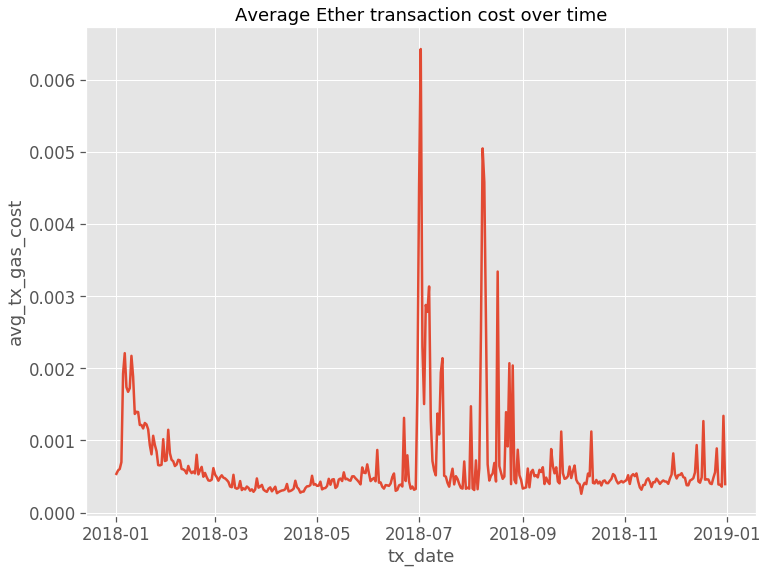

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

f, g = plt.subplots(figsize=(12, 9))
g = sns.lineplot(x="tx_date", y="avg_tx_gas_cost", data=df, palette="Blues_d")
plt.title("Average Ether transaction cost over time")
plt.show(g)

### Ether supply

In [79]:
query = """


with 
    ether_emitted_by_date  as (
              select date(block_timestamp) as date, sum(value) as value
              from `bigquery-public-data.crypto_ethereum.traces`
              where trace_type in ('genesis', 'reward')
              group by date(block_timestamp)
)
select date, sum(value) OVER (ORDER BY date) / power(10, 18) AS supply
from ether_emitted_by_date where date


"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df = df[df['date'] > '1970-01-01']
df.head()

Downloading: 100%|██████████| 1692/1692 [00:01<00:00, 1620.49rows/s]


,date,supply
0,1970-01-01,7.200999e+07
1,2015-07-30,7.204930e+07
2,2015-07-31,7.208549e+07
3,2015-08-01,7.211320e+07
4,2015-08-02,7.214142e+07


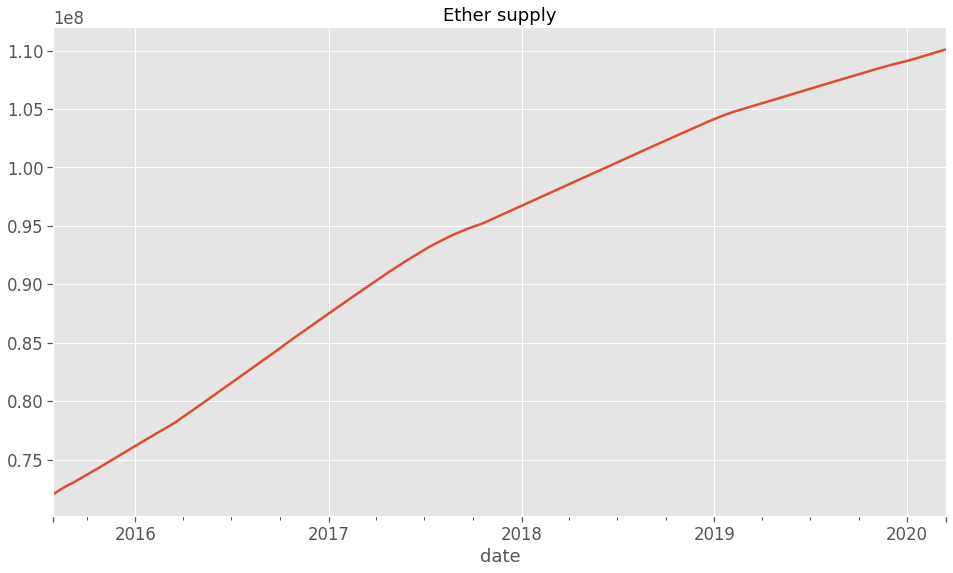

In [89]:
df.set_index('date')['supply'].plot(kind='line', figsize=(16,9), title='Ether supply');

### Ethereum addresses

In [ ]:
Features (user-level):
    - Number of token transfers per month since first transfer
    - Number of token held
    - Total value currently held

### Balances

This table contains Ether balances of all addresses, updated daily.

In [74]:
query = """
        select 
            address
            , (eth_balance / power(10, 18)) as eth_balance
        from
            `bigquery-public-data.crypto_ethereum.balances`
        limit 1000
        
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 1000/1000 [00:01<00:00, 950.84rows/s]


,address,eth_balance
0,0x40a93f3b1434491a93c75ad1819cdd3d58546fcb,0.0
1,0x3f719b739eaa99077025b00aca358fe366360ea2,0.0
2,0x33fed844da11b3b80ee6c8f08821e9af93f46760,0.0
3,0x24e600975997de3682eb6935b66126fcf0f48650,0.0
4,0x67f0e4d4e6164cc09765eb115d19e15ad31af977,0.0


In [75]:
df['eth_balance'] = df['eth_balance'].astype(int)

In [78]:
df.set_index('address')['eth_balance'].sort_values()

address
0x40a93f3b1434491a93c75ad1819cdd3d58546fcb     0
0x91571981f10ebf120581b66174ada3e9c5a49a7f     0
0x0000000000000000000000000000000000171879     0
0x000000000000000000000000000000000016a78e     0
0x2d1bfbe6566907630b1c03b12fc61e6005c9e434     0
                                              ..
0x1ebd75a5a0f3490373f161624a95866ccd67071c     9
0x29a9f180b1eea38861e353ddb2394d8563f9c7b5    10
0x699571de06fab6b0707d43d57d50f003356450bb    13
0x18482b0c69d7c876c1b0e8ea79a84bbf4f158aee    15
0x4a7dbe672a5990f61966943d72fcef2b9d65aa0c    19
Name: eth_balance, Length: 1000, dtype: int64

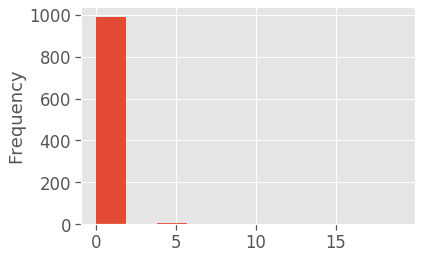

In [77]:
df.set_index('address')['eth_balance'].plot(kind='hist');

In [58]:
query = """
        select 
            count(distinct address)
        from
            `bigquery-public-data.crypto_ethereum.balances`
        
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.17rows/s]


,f0_
0,109055878


In [101]:
query = """
        select 
            count(distinct address)
        from
            `bigquery-public-data.crypto_ethereum.balances`
        where
            (eth_balance / power(10, 18)) > 1
        
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.16rows/s]


,f0_
0,265641


### 1/3 Ethereum addressed have values

36M non-zero balance Ethereum addresses. 109M total Ethereum addresses

In [67]:
f'{round((36995343 / 109055878)*100)} percent of Ethereum addresses have non-zero balance'

'34 percent of Ethereum addresses have non-zero balance'

### Tokens transfers

### ERC20 (fungible) and ERC 721 (non-fungible) token transfersm

In [50]:
pandas_gbq.read_gbq("select * from `bigquery-public-data.ethereum_blockchain.token_transfers` limit 10", credentials=credentials)



Downloading: 100%|██████████| 10/10 [00:00<00:00, 10.02rows/s]


,token_address,from_address,to_address,value,transaction_hash,log_index,block_timestamp,block_number,block_hash
0,0x89205a3a3b2a69de6dbf7f01ed13b2108b2c43e7,0x2d39c6a87251be894c6c2f758f7050f301128964,0x4e20fe4e216d86e1cb19dd9ee8879e3605a31e45,1,0xb2d9fc49dc27db13ec894b730821eef62d1b172408c5...,0,2016-09-17 10:33:00+00:00,2275509,0xb3335323bfd659ed61d4e92a050c8cb48c3cdbfaea37...
1,0x45e42d659d9f9466cd5df622506033145a9b89bc,0xd25a190092a16a8ad58d9f74b9cef7549ddeb90d,0x9d2df88cd351e0d1f5612f1d3587a06756043eeb,1000000,0x05e55acde165b4d26ed3f7f432947574965ee8fc64e5...,0,2016-09-17 00:25:59+00:00,2272959,0xec56674024563403106b1b3db6a59c3a34dfbebfca6c...
2,0x815a46107e5ee2291a76274dc879ce947a3f0850,0xac75b73394c329376c214663d92156afa864a77f,0x4aea7cf559f67cedcad07e12ae6bc00f07e8cf65,3996260000,0x750574039ed4c18df67665750b7dc9b9d911b67d155e...,67,2016-09-17 13:48:42+00:00,2276353,0xf3ee0ad1dfb37bf0e4a4a662523c22a3c550a14d837f...
3,0x01a7018e6d1fde8a68d12f59b6532fb523b6259d,0xac75b73394c329376c214663d92156afa864a77f,0x4aea7cf559f67cedcad07e12ae6bc00f07e8cf65,3996260000,0x750574039ed4c18df67665750b7dc9b9d911b67d155e...,68,2016-09-17 13:48:42+00:00,2276353,0xf3ee0ad1dfb37bf0e4a4a662523c22a3c550a14d837f...
4,0x45e42d659d9f9466cd5df622506033145a9b89bc,0xcb8dc434f89058cfb8b273d98a6366f5d718e2e1,0x9d2df88cd351e0d1f5612f1d3587a06756043eeb,1000000,0xabde28c3130fdcd3cf000b614486cc7e2224e1273541...,0,2016-09-17 00:23:14+00:00,2272948,0xf6a99494ea77dde2b745d025cb989cc767de265846f3...
5,0x74c1e4b8cae59269ec1d85d3d4f324396048f4ac,0xf7bc5d229374470e3adb671505c2c8a716810dc5,0xd04e62191b27fe60632c6999077000daeca12881,1,0xb3bcceaf538de8475e13b7051366fbbc12e5571b90ec...,0,2016-09-17 09:50:35+00:00,2275337,0x9eb32e9f9ae46fb7e38e77407c6a6adee55a322b8503...
6,0x9a526b18eeb7195b7324f7271fc02c6b5e11ff5e,0xce7f06ba27b3e525ccdfc559cea9e523e5f91eae,0x4aea7cf559f67cedcad07e12ae6bc00f07e8cf65,10000000000000000000,0x7aa5518aa7ba258b2c7b7ea18a4f209bbb0a05882723...,1,2016-09-17 15:19:42+00:00,2276713,0xe5f0245367115fa0057c4babf6138c8338e1a57f6bf8...
7,0x4b4ec8ec0ee6b1decf952c9547c664e95004eb32,0x71121c0afc711dbfdc67e95512b6f1e12aca378f,0x67b663465e4bbebc9a1a79ab47516ded6b5ab38f,4000,0xad73e1345f9c3ae7daa3711ecc14ea0e05680d7919a4...,0,2016-09-17 16:19:25+00:00,2276960,0x036eb83cb21fc840b4d49c8e50f6fbf16fe4325c0365...
8,0x4a41659df69d663d000764d3b235908e5937c6b2,0x2136bbba2edca21afdddee838fff19ea70d10f03,0x084c37f2c09f7aaf8c6cf4670d9f1925bdaf7205,1100000000000000000,0x84d2b4468e2edb6c3d3254def15cc8119d89441285a5...,0,2016-09-17 16:57:35+00:00,2277131,0x7e600225289b6359e3159cb571f942b7c5c0bd3534b1...
9,0x55e7c4a77821d5c50b4570b08f9f92896a25e012,0xce3b5ffca16fff926c890f0885a3e90ceb89db0a,0x69718e596943827550f3cb466dd09455544aa61c,60,0x0e196ff7d49c9724d533fb89e8221cb0d96ca316de98...,1,2016-09-17 10:28:12+00:00,2275487,0xb57e5046f2e7b47455d9e6deb5ba9cfd595ab35eb826...


### Number of tokens (from token transfers)

In [51]:
query = """
        select 
            count(distinct token_address)
        from
            `bigquery-public-data.ethereum_blockchain.token_transfers`
        
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.30rows/s]


,f0_
0,134465


### Token metadata

In [52]:
query = """
        select 
            *
        from
            `bigquery-public-data.ethereum_blockchain.tokens`
        limit 100
        
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

Downloading: 100%|██████████| 100/100 [00:00<00:00, 100.41rows/s]


,address,symbol,name,decimals,total_supply,block_timestamp,block_number,block_hash
0,0xc60397eb1a1dac133e459e78267fc735769a9c77,SOT,Staked Opportunity Token,None,None,2019-07-26 17:35:59+00:00,8227569,0xa9e2807fc0aabc97ebb50f1e20d0b7ceb0ff02ce35a5...
1,0x69ba896b3f011ffe2b7467bf3eee6e1055d5cbf8,SPRT,Staked Passive Return Token,None,None,2019-07-26 17:34:32+00:00,8227566,0x972398910e3a8e73e3422edc4cd088fc00d9cf273b0a...
2,0xe215e8160a5e0a03f2d6c7900b050f2f04ea5cbb,RAY,Robo Advisor for Yield,None,None,2019-09-09 19:27:12+00:00,8517566,0x641ce1866ca2629e6c0172d119cb70dbaf48adde442d...
3,0xc24e024f4955824ed42f5c1538eaaa4b32a8b12f,RAYT,Robo Advisor Yield Token,None,None,2019-08-29 20:51:13+00:00,8447369,0xde481f41e95539764f3721aaf7cacb3c79939d302290...
4,0x22e26f4a9fba1fa3aea3753e39f392fb9f1a1b27,RAY,Robo Advisor for Yield,None,None,2019-09-09 19:06:53+00:00,8517478,0x7cc19e480fefdbf4e2ae5b710b2c8d8db5f0f21c4ef4...


### Transactions metadata

Each block in the blockchain is composed of zero or more transactions. Each transaction has a source address, a target address, an amount of Ether transferred, and an array of input bytes.
This table contains a set of all transactions from all blocks, and contains a block identifier to get associated block-specific information associated with each transaction.am

In [ ]:
df = pandas_gbq.read_gbq("select distinct ", credentials=credentials)

In [ ]:
query = """

with top_tokens as (
  select token_address, count(1) as transfer_count
  from `bigquery-public-data.ethereum_blockchain.token_transfers` as token_transfers
  group by token_address
  order by transfer_count desc
  limit 1000
  
"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

### Token recommender

In [ ]:
query = """

with top_tokens as (
  select token_address, count(1) as transfer_count
  from `bigquery-public-data.ethereum_blockchain.token_transfers` as token_transfers
  group by token_address
  order by transfer_count desc
  limit 1000
),
token_balances as (
    with double_entry_book as (
        select token_address, to_address as address, cast(value as float64) as value, block_timestamp
        from `bigquery-public-data.ethereum_blockchain.token_transfers`
        union all
        select token_address, from_address as address, -cast(value as float64) as value, block_timestamp
        from `bigquery-public-data.ethereum_blockchain.token_transfers`
    )
    select double_entry_book.token_address, address, sum(value) as balance
    from double_entry_book
    join top_tokens on top_tokens.token_address = double_entry_book.token_address
    where address != '0x0000000000000000000000000000000000000000'
    group by token_address, address
    having balance > 0
),
token_supplies as (
    select token_address, sum(balance) as supply
    from token_balances
    group by token_address
)
select 
    token_balances.token_address, 
    token_balances.address as user_address, 
    balance/supply * 100 as rating
from token_balances
join token_supplies on token_supplies.token_address = token_balances.token_address
where balance/supply * 100 > 0.001
'''

"""

### Feature engineering

Features:
    - Current balance
    - Number of token transfers
    - Number of tokens held
    - Later: Diversification

In [ ]:
token_balances as (
    with double_entry_book as (
        -- credit
        select token_address, to_address as address, cast(value as float64) as value, block_timestamp
        from `bigquery-public-data.ethereum_blockchain.token_transfers`
        union all
        -- debit
        select token_address, from_address as address, -cast(value as float64) as value, block_timestamp
        from `bigquery-public-data.ethereum_blockchain.token_transfers`
    )
    select double_entry_book.token_address, address, sum(value) as balance
    from double_entry_book
    join top_tokens on top_tokens.token_address = double_entry_book.token_address
    where address != '0x0000000000000000000000000000000000000000'
    group by token_address, address
    having balance > 0
),

In [96]:
query = """

-- current ethereum balance for 1000 non-zero balance addresses
with ethereum_balance as (
        select 
            ethereum_address
            , (eth_balance / power(10, 18)) as eth_balance
        from
            `bigquery-public-data.crypto_ethereum.balances`
        where
            eth_balance > 0
        limit 1000),
   
-- number of tokens held
double_entry_book as (
        -- credit
        select 
            token_address
            , to_address as ethereum_address
            , cast(value as float64) as value
            , block_timestamp
        from 
            ethereum_balance a
        join
            `bigquery-public-data.ethereum_blockchain.token_transfers` b
        on
            a.ethereum_address = b.to_address
        union all
        -- debit
        select 
            token_address
            , from_address as ethereum_address
            , -cast(value as float64) as value
            , block_timestamp
        from 
            ethereum_balance a
        join
            `bigquery-public-data.ethereum_blockchain.token_transfers` b
        on
            a.ethereum_address = b.from_address
    )

select * from double_entry_book
    


"""

df = pandas_gbq.read_gbq(query, credentials=credentials)
df.head()

GenericGBQException: Reason: 400 Unrecognized name: ethereum_address at [6:13]